# **ADVANCED MACHINE LEARNING FINAL PROJECT**

##### Authors: Dario Della Mura - David Doci

##### Course: Advanced Machine Learning

##### Master's Degree: Data Science

##### Anno accademico: 2020/2021






Setting Colab GPU environment

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Feb  9 20:04:54 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Import Libraries and Fruit-360 Dataset

In [ ]:
# import Fruits-360 dataset from Github

!git clone 'https://github.com/Horea94/Fruit-Images-Dataset.git'

Cloning into 'Fruit-Images-Dataset'...
remote: Enumerating objects: 385858, done.
remote: Counting objects: 100% (8693/8693), done.
remote: Compressing objects: 100% (8672/8672), done.
remote: Total 385858 (delta 36), reused 8670 (delta 21), pack-reused 377165
Receiving objects: 100% (385858/385858), 2.10 GiB | 26.71 MiB/s, done.
Resolving deltas: 100% (1196/1196), done.
Checking out files: 100% (90503/90503), done.


In [ ]:
# Generiche
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import os
import glob
import cv2

# Keras
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D, Dropout, Activation, AveragePooling2D
from keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers 
import keras

# Sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# Setting Seed for project reproducibility
np.random.seed(1234)
tf.random.set_seed(1234)

## Data pre-processing

In [ ]:
# Pre-processing on training images and building images vector and classes vector
%%time

path_train = '/content/Fruit-Images-Dataset/Training/*'

fruit_train = []
fruit_label = []
for dir_path in glob.glob(path_train):
    img_label = dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (50,50))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        fruit_train.append(image)
        fruit_label.append(img_label)
fruit_train = np.array(fruit_train)
fruit_label = np.array(fruit_label)

CPU times: user 16.3 s, sys: 3.13 s, total: 19.4 s
Wall time: 19.9 s


In [ ]:
# class codification
%%time

# numerical label assignment to nominal classes
label_to_id = {v:k for k,v in enumerate(np.unique(fruit_label))}
id_to_label = {v:k for k,v in label_to_id.items() }
# assignment of numerical labels to the reference images
fruit_label_id = np.array([label_to_id[i] for i in fruit_label])

CPU times: user 52 ms, sys: 2.78 ms, total: 54.8 ms
Wall time: 54.9 ms


In [ ]:
%%time

fruit_label_id.shape

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 13.4 µs


(67692,)

In [ ]:
%%time

fruit_train[1].shape

CPU times: user 14 µs, sys: 3 µs, total: 17 µs
Wall time: 22.2 µs


(50, 50, 3)

In [ ]:
# Splitting images on training and validation sets
%%time

X_train, X_test, y_train, y_test = train_test_split(fruit_train, fruit_label_id, test_size=0.1, random_state=101)

CPU times: user 181 ms, sys: 863 ms, total: 1.04 s
Wall time: 893 ms


In [ ]:
%%time

print('Train size: ', len(X_train))
print('Test size: ', len(X_test))

Train size:  60922
Test size:  6770
CPU times: user 273 µs, sys: 63 µs, total: 336 µs
Wall time: 221 µs


In [ ]:
%%time
# Normalization of train and test(val) sets

X_train = X_train/255
X_test = X_test/255

CPU times: user 1.85 s, sys: 2.76 s, total: 4.61 s
Wall time: 4.64 s


In [ ]:
# One-hot-encoding on target variable

%%time
classes = 131
y_train_labels = to_categorical(y_train, classes)
y_test_labels = to_categorical(y_test, classes)

CPU times: user 13.5 ms, sys: 145 µs, total: 13.6 ms
Wall time: 14.2 ms


## Build CNN Model from scratch

In [ ]:
%%time

def build(width, height, depth, classes):
    #initialize the model along with the input shape
    initializer = tf.keras.initializers.GlorotUniform(seed=1234) 
    model = Sequential()
    inputShape = (height, width, depth)
    chanDim = -1
    if K.image_data_format() == 'channels_first':
        inputShape = (depth, height, width)
        chanDim = 1 

    model.add(Convolution2D(32, (3,3), padding='same', kernel_initializer=initializer,  input_shape=inputShape))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Convolution2D(64, (3,3), padding='same', kernel_initializer=initializer))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Convolution2D(128, (3,3), padding='same', kernel_initializer=initializer))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Convolution2D(256, (3,3), padding='same', kernel_initializer=initializer))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Flatten())
    model.add(Dense(32, kernel_initializer=initializer))
    model.add(Activation('relu'))
    model.add(Dropout(0.10))

    model.add(Dense(classes))
    model.add(Activation('softmax'))
    
    return model

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.68 µs


In [ ]:
# building model for (50,50,3) input image
import keras.backend as K
model = build(50, 50, 3, 131)

In [ ]:
# set loss function and optimizer of the model and evalutation metrics 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        896       
                                                                 
 activation (Activation)     (None, 50, 50, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 25, 25, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                    

In [ ]:
# Neural network training
%%time
with tf.device('/device:GPU:0'):  
  history = model.fit(X_train, y_train_labels, epochs=40, batch_size=32,  validation_split=0.30)

Epoch 1/40
1333/1333 [==============================] - 36s 20ms/step - loss: 2.4034 - accuracy: 0.4029 - val_loss: 0.6252 - val_accuracy: 0.8505
Epoch 2/40
1333/1333 [==============================] - 23s 17ms/step - loss: 1.0664 - accuracy: 0.7098 - val_loss: 0.3015 - val_accuracy: 0.9441
Epoch 3/40
1333/1333 [==============================] - 24s 18ms/step - loss: 0.8196 - accuracy: 0.7753 - val_loss: 0.1854 - val_accuracy: 0.9775
Epoch 4/40
1333/1333 [==============================] - 24s 18ms/step - loss: 0.6425 - accuracy: 0.8150 - val_loss: 0.0836 - val_accuracy: 0.9873
Epoch 5/40
1333/1333 [==============================] - 26s 19ms/step - loss: 0.5023 - accuracy: 0.8505 - val_loss: 0.0738 - val_accuracy: 0.9876
Epoch 6/40
1333/1333 [==============================] - 24s 18ms/step - loss: 0.4415 - accuracy: 0.8655 - val_loss: 0.0564 - val_accuracy: 0.9919
Epoch 7/40
1333/1333 [==============================] - 24s 18ms/step - loss: 0.3908 - accuracy: 0.8806 - val_loss: 0.0317 -

### Results on training

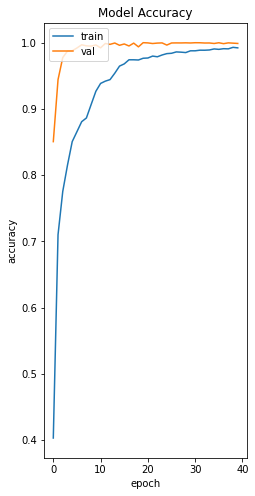

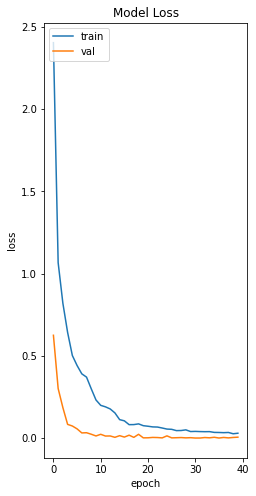

CPU times: user 417 ms, sys: 17.7 ms, total: 435 ms
Wall time: 483 ms


In [ ]:
# accuracy and loss chart of the model
%%time

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Performance of the neural network built from scratch on val set

score = model.evaluate(X_test, y_test_labels, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0022673998028039932
Test accuracy: 0.999556839466095


In [ ]:
# Use of the previous trained neural network to predict the class of the images of the val set
%%time

predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)
print(classification_report(classes_x, y_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        59
           1       1.00      1.00      1.00        51
           2       1.00      1.00      1.00        53
           3       1.00      1.00      1.00        52
           4       1.00      1.00      1.00        51
           5       1.00      1.00      1.00        42
           6       0.98      1.00      0.99        46
           7       1.00      1.00      1.00        55
           8       1.00      1.00      1.00        61
           9       1.00      1.00      1.00        46
          10       1.00      1.00      1.00        60
          11       1.00      1.00      1.00        48
          12       1.00      1.00      1.00        61
          13       1.00      1.00      1.00        49
          14       1.00      1.00      1.00        43
          15       1.00      1.00      1.00        43
          16       1.00      1.00      1.00        53
          17       1.00    

In [ ]:
#save model for future evaluation

# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Testing on unseen images

In [ ]:
#upload pre-trained model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [ ]:
# Pre-processing on training images and building images vector and classes vector
%%time

path_test = '/content/Fruit-Images-Dataset/Test/*'

fruit_test = []
fruit_test_label = []
for dir_path in glob.glob(path_test):
    img_label = dir_path.split("/")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (50,50))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        fruit_test.append(image)
        fruit_test_label.append(img_label)
fruit_test = np.array(fruit_test)
fruit_test_label = np.array(fruit_test_label)

CPU times: user 6.36 s, sys: 2.33 s, total: 8.7 s
Wall time: 16.1 s


In [ ]:
# class codification
%%time

# numerical label assignment to nominal classes
label_to_id_test = {v:k for k,v in enumerate(np.unique(fruit_test_label)) }
id_to_label_test = {v:k for k,v in label_to_id_test.items() }
# assignment of numerical labels to the reference images
fruit_label_test_id = np.array([label_to_id_test[i] for i in fruit_test_label])

CPU times: user 19.4 ms, sys: 347 µs, total: 19.7 ms
Wall time: 21.3 ms


In [ ]:
%%time

fruit_label_test_id.shape

CPU times: user 6 µs, sys: 1e+03 ns, total: 7 µs
Wall time: 10 µs


(22688,)

In [ ]:
# Normalization of test images
%%time
fruit_test = fruit_test/255.0

CPU times: user 627 ms, sys: 1.65 s, total: 2.28 s
Wall time: 1.92 s


In [ ]:
# One-hot encoding
%%time
classes=131
y_fruit_test_labels = to_categorical(fruit_label_test_id, classes)

CPU times: user 5.01 ms, sys: 2.06 ms, total: 7.07 ms
Wall time: 7.12 ms


In [ ]:
loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Using the previous trained neural network to predict the class of test set images
%%time
pred_test = loaded_model.predict(fruit_test)

CPU times: user 4.76 s, sys: 1.76 s, total: 6.52 s
Wall time: 7.55 s


In [ ]:
pred_test = np.argmax(pred_test, axis=1)

### Results on test

In [ ]:
# Performance of the neural network built from scratch on the test images not used in the training phase
%%time
score_test =loaded_model.evaluate(fruit_test, y_fruit_test_labels, verbose=0)
print("Test loss:", score_test[0])
print("Test accuracy:", score_test[1])

Test loss: 0.4109913408756256
Test accuracy: 0.9619622826576233
CPU times: user 5.31 s, sys: 1.21 s, total: 6.52 s
Wall time: 6.76 s


In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

cm = confusion_matrix(fruit_label_test_id, pred_test)

df_cm = pd.DataFrame(cm)
#plt.figure(figsize = (20, 20))
#sn.heatmap(df_cm, annot=True)

In [ ]:
df_cm.to_csv('cf_model_1.csv')

In [ ]:
print(classification_report(  fruit_label_test_id, pred_test))

              precision    recall  f1-score   support

           0       1.00      0.69      0.82       164
           1       1.00      0.30      0.47       148
           2       1.00      0.86      0.92       160
           3       0.88      1.00      0.93       164
           4       0.93      1.00      0.96       161
           5       1.00      1.00      1.00       164
           6       0.57      0.89      0.69       152
           7       0.92      0.85      0.88       164
           8       0.95      1.00      0.97       164
           9       1.00      1.00      1.00       144
          10       1.00      1.00      1.00       166
          11       0.88      1.00      0.93       164
          12       1.00      1.00      1.00       219
          13       1.00      1.00      1.00       164
          14       1.00      1.00      1.00       143
          15       0.91      1.00      0.95       166
          16       1.00      0.89      0.94       166
          17       0.96    

In [ ]:
import pandas as pd

df = pd.read_csv('/content/cf_model_1.csv')

In [ ]:
df = df.drop(columns=['Unnamed: 0'])

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130
0,113,0,0,0,0,0,0,12,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
1,0,45,0,0,0,0,103,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,137,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,164,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,161,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,127,0,0,0,0
127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,153,0,0,0
128,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,158,0,0
129,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,249,0


In [ ]:
df.to_excel('cf_model_1.xlsx')